<a href="https://colab.research.google.com/github/adit333/handson_machine_learning/blob/main/dimensionality_reduction_ch8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Dimensionality Reduction***

In [4]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# **Principal Component Analysis**

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

## Principal Components

In [7]:
import numpy as np

# X = [...]  # the small 3D dataset was created ealier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [8]:
# extra code – shows how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

## Projecting Down to d Dimensions

In [9]:
W2 = Vt[:2].T
X2D = X_centered @ W2

## Using Scikit-Learn

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [11]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

## Explained Variance Ratio

In [12]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

The first dimension explains about 76% of the variance, while the second explains about 15%.

By projecting down to 2D, we lost about 9% of the variance:

In [13]:
1 - pca.explained_variance_ratio_.sum()

0.09028309326742034

## Choosing the Right Number of Dimensions

### Option 1: checking than retraining

In [14]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [15]:
d

154

In [16]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [17]:
pca.explained_variance_ratio_.sum()

0.9501960192613033

### Option 3: Check elbow of expected ration cummulative sum graph

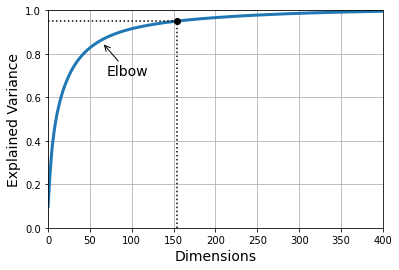

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

### Option 3: Use Randmoized Search CV

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       

In [20]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


## PCA for Compression

We will continue using MNIST as our example

Compression:

In [21]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [22]:
X_train.shape

(60000, 784)

In [23]:
X_reduced.shape

(60000, 154)

Decompression:

In [24]:
X_recovered = pca.inverse_transform(X_reduced)

In [25]:
X_recovered.shape

(60000, 784)

Reconstruction error:

In [26]:
np.linalg.norm(X_train - X_recovered)

101217.65566707801

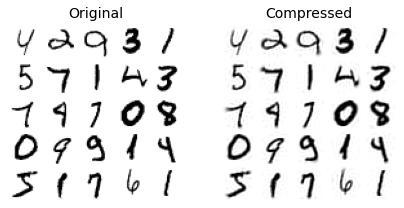

In [27]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

# Random Projections

As its name suggests, the Random Projection algorithm projects the data to a lower-dimensional space using a random linear projection. This may sound crazy, but it turns out that such a random projection is actually very likely to preserve distances fairly well, as was demonstrated mathematically by William B. Johnson and Joram Lindenstrauss in a famous lemma. So two similar instances will remain similar after the projection, and two very different instances will remain very different.

In [28]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

In [29]:
# extra code – show the equation computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

In [30]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T

In [31]:
X.shape

(5000, 20000)

In [32]:
P.T.shape

(20000, 7300)

In [33]:
X_reduced.shape

(5000, 7300)

That’s all there is to it! It’s simple and efficient, and no training is required: the only thing the algorithm needs to create the random matrix is the dataset’s shape, that’s it. The data itself is not used at all

If you want to perform the inverse transform, you first need to compute the pseudo-inverse of the components matrix, using SciPy’s pinv() function, then multiply the reduced data by the transpose of the pseudo-inverse:

Scikit-Learn offers a GaussianRandomProjection class to do exactly what we just did

In [34]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

In [35]:
# Takes long time to compute pseudo inverse: complexity is O(dn^2)
#components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
#X_recovered = X_reduced @ components_pinv.T

#### SparseRandomProjection

Scikit-Learn provides a second random projection transformer: SparseRandomProjection. It determines the target dimensionality in the same way, it generates a random matrix of the same shape, and it performs the projection identically. The main difference is that the random matrix is sparse. This means it uses much less memory: about 25 MB instead of almost 1.2GB in the preceding example! And it’s also much faster, both to generate the random matrix and to reduce dimensionality: about 50% faster on the preceding example. Moreover, if the input is sparse, the transformation keeps it sparse (unless you set dense_output=True). Lastly, it enjoys the same distance-preserving property as the previous approach, and the quality of the dimensionality reduction is comparable. In short, it’s usually preferable to use this transformer instead of the first one, especially for large or sparse datasets.

In [36]:
from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
1 loop, best of 5: 6.43 s per loop
SparseRandomProjection fit
1 loop, best of 5: 3.07 s per loop
GaussianRandomProjection transform
1 loop, best of 5: 43.4 s per loop
SparseRandomProjection transform
1 loop, best of 5: 6.81 s per loop


# **Locally Linear Embedding**

Locally Linear Embedding (LLE)⁠ is a nonlinear dimensionality reduction (NLDR) technique. It is a Manifold Learning technique that does not rely on projections, unlike PCA and Random Projection. In a nutshell, LLE works by first measuring how each training instance linearly relates to its nearest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

The following code makes a Swiss roll then uses Scikit-Learn’s LocallyLinearEmbedding class to unroll it:

In [37]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

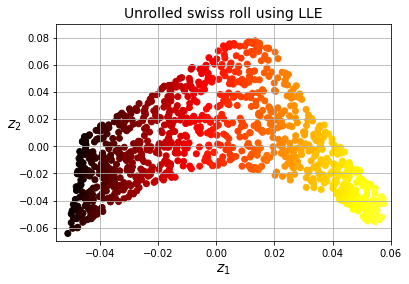

In [39]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()

# **Other Dimensionality Reduction Tehniques**

## Multidimensional Scaling

In [40]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

## Isomap

In [41]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

## t-SNE

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

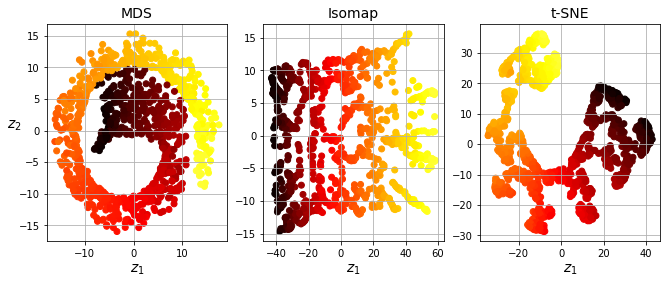

In [43]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()

That's it for now 😎